# Imports

In [1]:
#General imports
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

#Preprocessing
from preprocessing import load_data, creer_feature_ligne

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Amélioration de la RF par ajout des moyennes mobiles

  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_22696\3658350243.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['moving_average'] = df.groupby('ligne')['retard_moyen_arrivee'].apply(lambda x: x.rolling(k).mean().shift())
  8%|▊         | 1/12 [00:00<00:08,  1.30it/s]C:\Users\User\AppData\Local\Temp\ipykernel_22696\3658350243.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt th

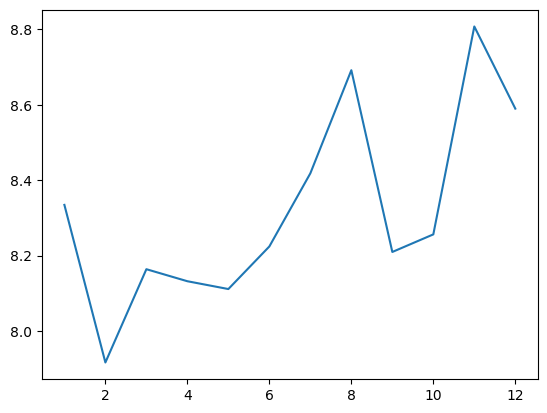

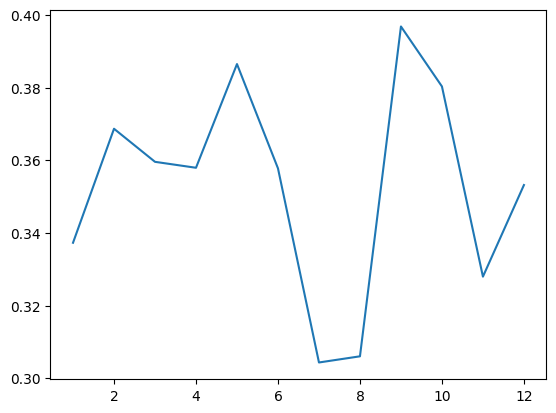

Le gain optimal est obtenu pour k=2 et permet un diminution de l'erreur de 5.01455557932356%.


In [120]:
data = load_data()

#PREPROCESSING
creer_feature_ligne(data)

data['mois'], data['annee'] = data['date'].apply(lambda date: date.split('-')[1]),  data['date'].apply(lambda date: date.split('-')[0])

def add_moving_average(data, k):
    if k>0:
        df = copy.deepcopy(data)
        df.sort_values(['ligne', 'annee', 'mois'], inplace=True)
        df['moving_average'] = df.groupby('ligne')['retard_moyen_arrivee'].apply(lambda x: x.rolling(k).mean().shift())
        df.sort_index(inplace=True)
        df = df[df['moving_average'].notna()]
        return df
    else:
        return data

# RECHERCHE DE LA FENETRE OPTIMALE
num_months = list()
maes = list()
r2s = list()

def test_moving_averages(data):
    for k in tqdm(range(1,13)):
        df = add_moving_average(data,k)
        X = df[['service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu', 'ligne', 'mois', 'moving_average']]
        y = df['retard_moyen_arrivee']
        # One-Hot Encoding pour les colonnes catégorielles
        X = pd.get_dummies(X, columns=['gare_depart', 'gare_arrivee', 'service', 'ligne'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf = RandomForestRegressor(n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=None, bootstrap=True)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        num_months.append(k)
        maes.append(mae)
        r2s.append(r2)
    
    plt.plot(num_months, maes)
    plt.show()
    plt.plot(num_months, r2s)
    plt.show()
test_moving_averages(data)
print(f"Le gain optimal est obtenu pour k={1+np.argmin(np.array(maes))} et permet un diminution de l'erreur de {(-min(maes)+maes[0])/maes[0]*100}%.")